In [1]:
import torch
import torch_directml
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [2]:
# Define paths and parameters
train_cars_dataset_path = 'data/cars_train/train'
test_cars_dataset_path = 'data/cars_train/test'
mean = [0.4708, 0.4602, 0.4550]
std = [0.2593, 0.2584, 0.2634]

train_cars_transforms = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_cars_transforms = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

train_cars_dataset = ImageFolder(root=train_cars_dataset_path, transform=train_cars_transforms)
test_cars_dataset = ImageFolder(root=test_cars_dataset_path, transform=test_cars_transforms)

train_cars_loader = DataLoader(train_cars_dataset, batch_size=32, shuffle=True)
test_cars_loader = DataLoader(test_cars_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([ 37,  54,  92, 146, 125,  84])


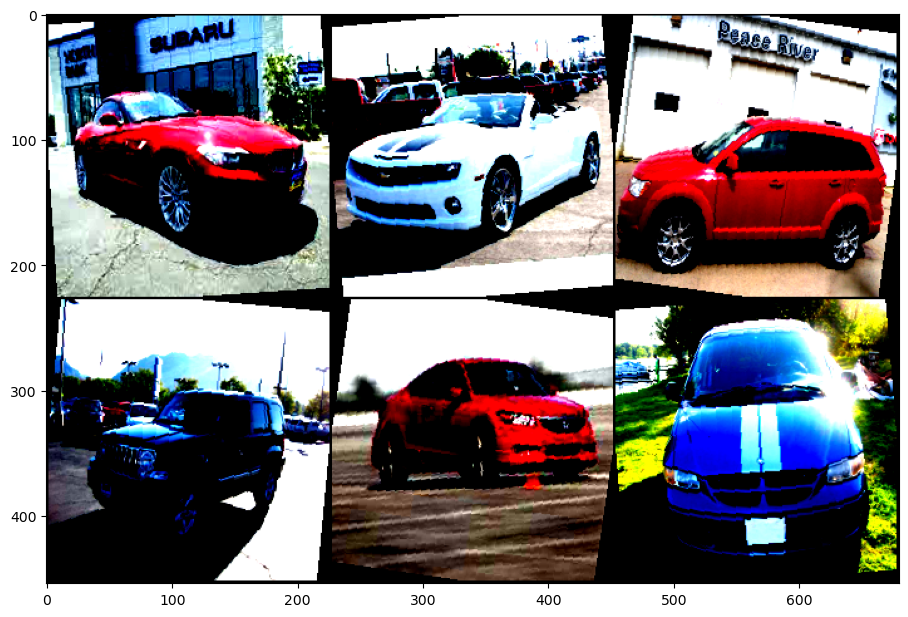

In [3]:
def show_transformed_images(dataset: ImageFolder, num_images: int = 6):
  loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
  batch = next(iter(loader))
  images, labels = batch

  print(f"Labels: {labels}")
  grid = torchvision.utils.make_grid(images, nrow=3)
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid, (1, 2, 0)))
  plt.show()

show_transformed_images(train_cars_dataset)

In [4]:
def get_device():
  """
  Returns the device to use for computations.
  Prioritizes DirectML device if available, otherwise falls back to CPU.
  """
  device = torch_directml.device() if torch_directml.is_available() else torch.device("cpu")
  return device

def save_checkpoint(model: torch.nn.Module, epoch: int, optimizer: torch.optim.Optimizer, best_acc: float):
    state = {
        'model': model.state_dict(),
        'epoch': epoch,
        'optimizer': optimizer.state_dict(),
        'best_acc': best_acc
    }
    torch.save(state, 'best_cars_model_checkpoint.pth.tar')

def train_cars_nn(model: torch.nn.Module, train_loader: DataLoader, test_loader: DataLoader, criterion: torch.nn.CrossEntropyLoss, optimizer: torch.optim.Optimizer, n_epochs: int):
    device = get_device()
    best_acc = 0

    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for images, labels in tqdm(train_loader, desc='Training loop'):
            images, labels = images.to(device), labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * running_correct / total

        print(f"    Training: Predicted {running_correct} of {total} images correctly (Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.2f}%)")

        eval_acc = evaluate_model(model, test_loader)

        if eval_acc > best_acc:
            best_acc = eval_acc
            save_checkpoint(model, epoch + 1, optimizer, best_acc)

    return model

def evaluate_model(model: torch.nn.Module, test_loader: DataLoader):
    model.eval()
    device = get_device()
    predicted_correctly = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            total += labels.size(0)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_correctly += (predicted == labels).sum().item()

    accuracy = 100 * predicted_correctly / total
    print(f"    Testing: Predicted {predicted_correctly} of {total} images correctly (Acc: {accuracy:.2f}%)")

    return accuracy

In [5]:
resnet18_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
n_features = resnet18_model.fc.in_features
n_classes = len(train_cars_dataset.classes)
resnet18_model.fc = torch.nn.Linear(n_features, n_classes)
device = get_device()
resnet18_model = resnet18_model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

train_cars_nn(resnet18_model, train_cars_loader, test_cars_loader, loss_fn, optimizer, n_epochs=20)

Epoch 1/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 742.0 of 6442 images correctly (Loss: 4.3108 - Acc: 11.52%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 391 of 1702 images correctly (Acc: 22.97%)
Epoch 2/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 2745.0 of 6442 images correctly (Loss: 2.2690 - Acc: 42.61%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 564 of 1702 images correctly (Acc: 33.14%)
Epoch 3/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 4205.0 of 6442 images correctly (Loss: 1.3780 - Acc: 65.27%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 897 of 1702 images correctly (Acc: 52.70%)
Epoch 4/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 4918.0 of 6442 images correctly (Loss: 0.9587 - Acc: 76.34%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 922 of 1702 images correctly (Acc: 54.17%)
Epoch 5/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5330.0 of 6442 images correctly (Loss: 0.7351 - Acc: 82.74%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1046 of 1702 images correctly (Acc: 61.46%)
Epoch 6/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5614.0 of 6442 images correctly (Loss: 0.5626 - Acc: 87.15%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1080 of 1702 images correctly (Acc: 63.45%)
Epoch 7/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5890.0 of 6442 images correctly (Loss: 0.4302 - Acc: 91.43%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1073 of 1702 images correctly (Acc: 63.04%)
Epoch 8/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6046.0 of 6442 images correctly (Loss: 0.3613 - Acc: 93.85%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1077 of 1702 images correctly (Acc: 63.28%)
Epoch 9/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6117.0 of 6442 images correctly (Loss: 0.3120 - Acc: 94.95%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1184 of 1702 images correctly (Acc: 69.57%)
Epoch 10/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6210.0 of 6442 images correctly (Loss: 0.2667 - Acc: 96.40%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1158 of 1702 images correctly (Acc: 68.04%)
Epoch 11/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6191.0 of 6442 images correctly (Loss: 0.2872 - Acc: 96.10%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1039 of 1702 images correctly (Acc: 61.05%)
Epoch 12/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6175.0 of 6442 images correctly (Loss: 0.3089 - Acc: 95.86%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1038 of 1702 images correctly (Acc: 60.99%)
Epoch 13/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6179.0 of 6442 images correctly (Loss: 0.3158 - Acc: 95.92%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1069 of 1702 images correctly (Acc: 62.81%)
Epoch 14/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6038.0 of 6442 images correctly (Loss: 0.4102 - Acc: 93.73%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 997 of 1702 images correctly (Acc: 58.58%)
Epoch 15/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5993.0 of 6442 images correctly (Loss: 0.4300 - Acc: 93.03%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1046 of 1702 images correctly (Acc: 61.46%)
Epoch 16/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5962.0 of 6442 images correctly (Loss: 0.4472 - Acc: 92.55%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1010 of 1702 images correctly (Acc: 59.34%)
Epoch 17/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5900.0 of 6442 images correctly (Loss: 0.4580 - Acc: 91.59%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 858 of 1702 images correctly (Acc: 50.41%)
Epoch 18/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5956.0 of 6442 images correctly (Loss: 0.4430 - Acc: 92.46%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1005 of 1702 images correctly (Acc: 59.05%)
Epoch 19/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 5983.0 of 6442 images correctly (Loss: 0.4267 - Acc: 92.87%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 850 of 1702 images correctly (Acc: 49.94%)
Epoch 20/20


Training loop:   0%|          | 0/202 [00:00<?, ?it/s]

    Training: Predicted 6132.0 of 6442 images correctly (Loss: 0.3331 - Acc: 95.19%)


Validation loop:   0%|          | 0/54 [00:00<?, ?it/s]

    Testing: Predicted 1034 of 1702 images correctly (Acc: 60.75%)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
checkpoint = torch.load('best_cars_model_checkpoint.pth.tar')
checkpoint.get('best_acc')

69.56521739130434

In [6]:
resnet18_model = torchvision.models.resnet18()
n_features = resnet18_model.fc.in_features
n_classes = len(train_cars_dataset.classes)
resnet18_model.fc = torch.nn.Linear(n_features, n_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, 'best_cars_model.pth')